Предположим, что у нас есть сразу эмбеддинги в файле words.csv

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json

from sklearn.cluster import KMeans, kmeans_plusplus
from tqdm import tqdm

In [34]:
words = pd.read_csv('words.csv')
words = words.set_index('Unnamed: 0')
words

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
удовольствие,0.026174,0.037918,-0.025903,0.025854,-0.082688,-0.019163,0.165963,0.027660,0.012059,-0.013564,...,-0.021249,0.077424,0.048163,-0.010788,-0.029331,-0.007624,-0.016468,0.046724,-0.015729,-0.015422
интерес,0.005865,0.035545,-0.048719,0.049162,-0.089950,0.039788,0.125447,0.098759,0.087505,-0.025387,...,0.016641,0.018871,0.081901,-0.043197,-0.037455,0.040578,0.048341,-0.053629,0.044542,0.014680
удовлетворение,-0.014962,0.028453,-0.044035,0.007704,-0.119207,0.031895,0.155695,0.060122,-0.015981,-0.012629,...,-0.019666,0.076287,0.030888,-0.020628,-0.049212,0.008329,-0.022519,0.040449,-0.019890,-0.009755
признание,-0.021111,0.022839,-0.037340,-0.003636,-0.123124,0.064397,0.217956,0.038475,0.013418,-0.052965,...,-0.042848,0.060673,0.029276,0.019155,-0.106798,0.000821,-0.005561,-0.002290,0.022968,-0.079636
возможность,0.002700,0.096520,0.004013,-0.003704,-0.048581,0.023773,0.176784,0.086606,-0.025916,-0.077367,...,0.009639,0.072470,0.019286,-0.032288,-0.067272,-0.042420,-0.018439,0.070175,-0.008629,0.016010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
обучение,-0.001817,0.058661,-0.030851,0.054416,-0.049466,0.047364,0.124756,0.129233,0.003721,-0.092033,...,-0.013953,0.106578,0.083407,0.027854,-0.005021,0.039695,-0.048903,-0.025230,-0.021118,-0.094945
путешествие,0.060054,0.074989,0.007691,0.026440,-0.078679,-0.021105,0.138764,0.084017,0.039457,-0.059401,...,-0.035963,0.081803,0.074716,-0.010437,-0.018786,-0.001609,0.140868,0.035612,-0.010439,0.008144
эксперимент,0.018112,0.081045,-0.051732,0.003911,-0.075784,0.082712,0.151356,0.096624,0.009833,-0.021309,...,-0.012283,0.056659,0.084739,-0.003070,-0.060174,0.005916,-0.003407,0.028288,0.015651,0.033129


Кластеризуем с помощью kmeans_plusplus и найдем инерцию, по ней определим количество кластеров

In [35]:
word_vectors = np.array(words)

ran = range(1, min(words.shape[1] + 1, 50))
inertia_df = pd.DataFrame(data=[], index=ran, columns=['inertia'])
effective_clusters = -1
for n_clusters in tqdm(ran):
    try:
        effective_clusters += 1
        centers, indices = kmeans_plusplus(np.array(word_vectors), n_clusters=n_clusters, random_state=10)
        kmeans = KMeans(n_clusters=n_clusters,  random_state=42)
        cluster_labels = kmeans.fit_predict(word_vectors)
        inertia_df.loc[n_clusters] = kmeans.inertia_
    except:
        break
inertia_df = inertia_df.iloc[:effective_clusters]

100%|██████████| 49/49 [00:01<00:00, 29.84it/s]


<Axes: >

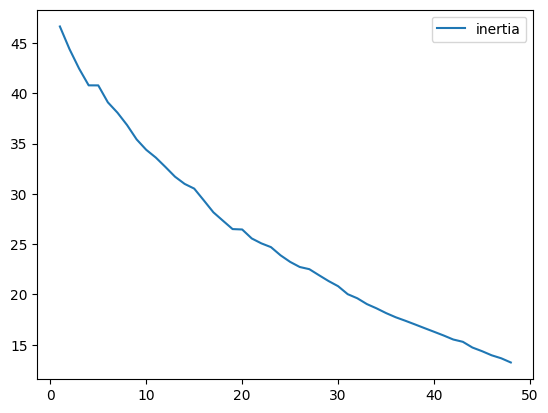

In [12]:
inertia_df.plot()

Представим инерцию и ее производную в нормальном виде. По производной тоже были попытки найти количество кластеров, но они оказались неудачными.

In [13]:
inertia_arr = np.array(inertia_df).flatten()
inertia_derivative = inertia_arr[:-1] - inertia_arr[1:]

Реализуем класс GradientDescent

In [14]:
class GradientDescent(object):
    def __init__(self, a=1.0, b=0.0, x0=1.0, l=1e-2):
        self.a = a
        self.b = b
        self.x0 = x0
        self.l = l
        self.loss = []

    def f(self, x, y, a, b, x0):
        return 0.5 * pow(y - a * np.exp(-x / x0) - b, 2).sum()

    def dfda(self, x, y, a, b, x0):
        return ((a * np.exp(-x / x0) + b - y) * np.exp(-x / x0)).sum()

    def dfdb(self, x, y, a, b, x0):
        return (a * np.exp(-x / x0) + b - y).sum()

    def dfdx0(self, x, y, a, b, x0):
        return ((a * np.exp(-x / x0) + b - y) * a * np.exp(-x / x0) * x / pow(x0, 2)).sum()

    def fit(self, x, y, epochs=1_000):
        self.loss.append(self.f(x, y, self.a, self.b, self.x0))
        for epoch in tqdm(range(epochs)):
            self.a -= self.l * self.dfda(x, y, self.a, self.b, self.x0)
            self.b -= self.l * self.dfdb(x, y, self.a, self.b, self.x0)
            self.x0 -= self.l* self.dfdx0(x, y, self.a, self.b, self.x0)
            self.loss.append(self.f(x, y, self.a, self.b, self.x0))

    def get_a_b_x0(self):
        return self.a, self.b, self.x0

Идея такая. В физике есть радиус Дебая - такое расстояние, при котором взаимодействие уменьшается в $e$ раз. Дебаевский радиус - эффективный размер распространения взаимодействия. Давайте сделаем то же самое с инерцией - дебаевским расстоянием будет количество кластеров, на котором апроксимированная функцией $f(x)$ инерция будет уменьшаться в $e$ раз.

Изначально я хотел заменить инерцию на более гладкую $f(x) = a \cdot e^{-\frac{x}{x_0}} + b$, где $a, b, x_0$ - настраиваемые параметры - как раз град спуск для них. Но потом подумал, что можно сразу использовать дебаевский формализм к инерции без преобразования.

Использование гладкой $f(x) = a \cdot e^{\frac{x}{x_0}} + b$ позволяет убрать различные выбросы и зигзаги (например, у производной инерции - там явно выражена негладкость). По факту, количество кластеров можно выбирать как $n = \lceil x_0 \rceil + 1$.

In [16]:
x, y = np.array(range(inertia_arr.shape[0])), np.array(inertia_arr).flatten()
y_norm = y.max()
y /= y_norm

grad = GradientDescent(a=1.0, b=0.0, x0=1.0, l=1e-2)
grad.fit(x, y, epochs=100_000)

100%|██████████| 100000/100000 [00:17<00:00, 5576.01it/s]


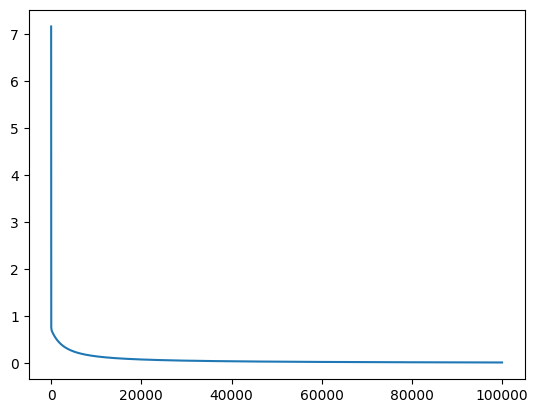

In [17]:
plt.plot(grad.loss)

In [18]:
a, b, x0 = grad.get_a_b_x0()
a, b, x0

(0.7408963975080299, 0.2933945587180001, 16.983673235679383)

In [19]:
ind = np.ceil(x0).astype(int)
print(f'Количество кластеров {ind} + 1')

Количество кластеров 17 + 1


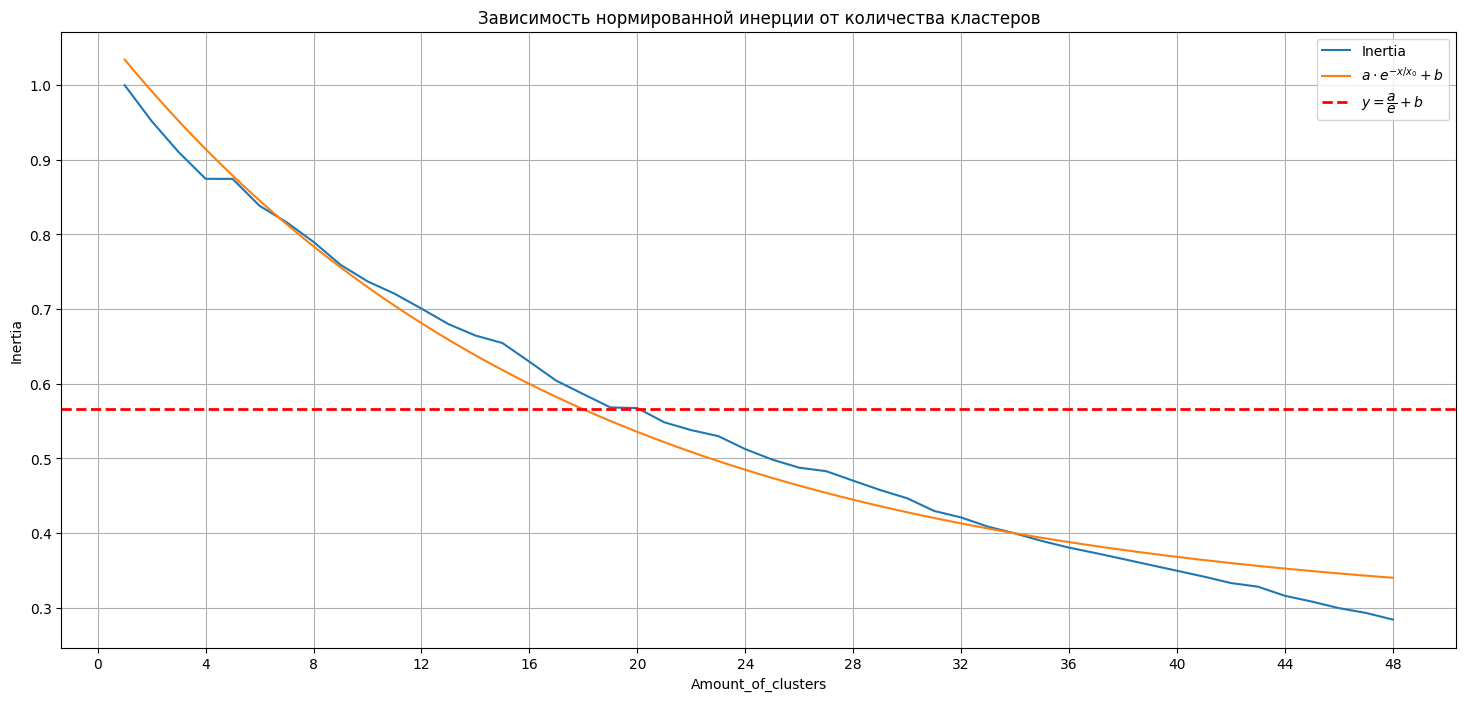

In [28]:
t = np.linspace(x.min(), x.max(), 1000)
y_pred = a * np.exp(-t / x0) + b

plt.figure(figsize=(18, 8))
plt.title('Зависимость нормированной инерции от количества кластеров')
plt.plot(x + 1, y.flatten(), label='Inertia')
plt.plot(t + 1, y_pred, label='$a \cdot e^{-x/x_0} + b$')
plt.axhline(y= a / np.e + b, color='r', linestyle='--', linewidth=2, label='$y = \dfrac{a}{e} + b$')
plt.xticks(range(0, inertia_arr[1:].shape[0] + 4, 4))
plt.xlabel('Amount_of_clusters')
plt.ylabel('Inertia')
plt.legend()
plt.grid()

Кластеризуем в соответствии с найденными кластерами

In [45]:
n_clusters = ind + 1
centers, indices = kmeans_plusplus(np.array(word_vectors), n_clusters=n_clusters, random_state=10)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(word_vectors)

df = pd.DataFrame(np.array(words.index), columns=['word'])
df['cluster'] = cluster_labels

Выберем рандомное слово в каждом кластере и посчитаем сколько слов всего в кластере

In [48]:
counter = {}
for i in range(n_clusters):
    w = np.random.choice(df[df['cluster'] == i]['word'])
    amount = df[df['cluster'] == i].shape[0]
    counter[w] = amount
counter

{'качество': 5,
 'доход': 9,
 'разнообразие': 4,
 'идея': 15,
 'карьера': 3,
 'социальный статус': 6,
 'популярность': 10,
 'карьерный рост': 10,
 'деньга': 5,
 'ответ': 5,
 'финансы': 2,
 'вознаграждение': 5,
 'цель': 6,
 'энергия': 4,
 'комфорт': 4,
 'репутация': 4,
 'фидбек': 5,
 'мобильность': 4}

Сохраним этот словарь в формате JSON

In [49]:
with open('counter_data.json', 'w') as json_file:
    json.dump(counter, json_file, indent=4)

Визуализируем в **seaborn**

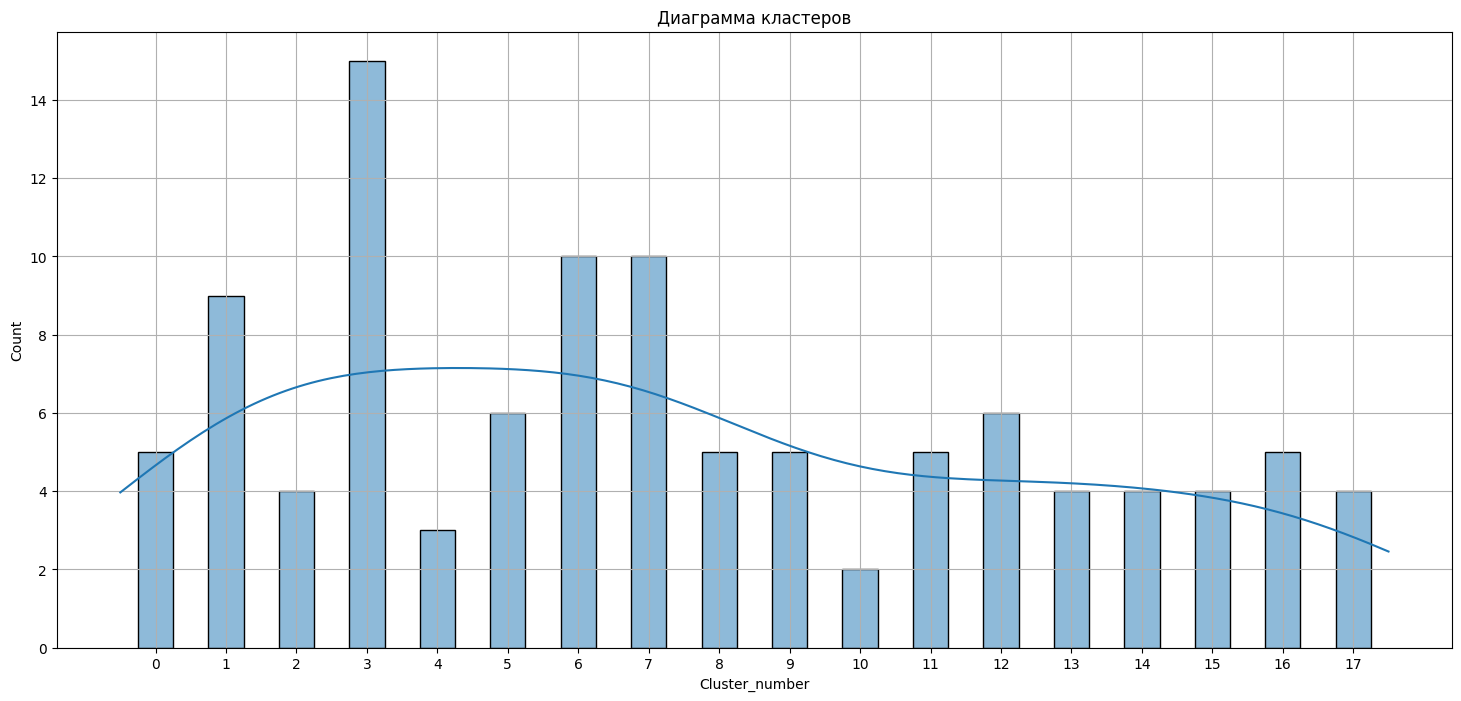

In [50]:
plt.figure(figsize=(18, 8))
ax = sns.histplot(cluster_labels, bins=n_clusters, shrink=0.5, kde=True)

bin_edges = ax.patches[0].get_bbox().bounds

centers = [patch.get_x() + patch.get_width() / 2 for patch in ax.patches]

plt.title('Диаграмма кластеров')
plt.xticks(centers, np.arange(n_clusters))
plt.yticks(range(0, max(counter.values()) + 1, 2))
plt.xlabel('Cluster_number')
plt.grid()

plt.show()

Как итог, у нас есть аналог словаря частотности слов